# Market Microstructure Project

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from scipy.integrate import quad
from scipy.optimize import minimize

## Initial parameters

In [2]:
pi_i = 0.4
S0 = 19.90
S = [10, 33]
k = 60
lambda_ = 3

## Distribution

In [3]:
def pdf(l, k, x):
    return (l ** k * x ** (k - 1) * np.exp(-l * x)) / math.factorial(k - 1)

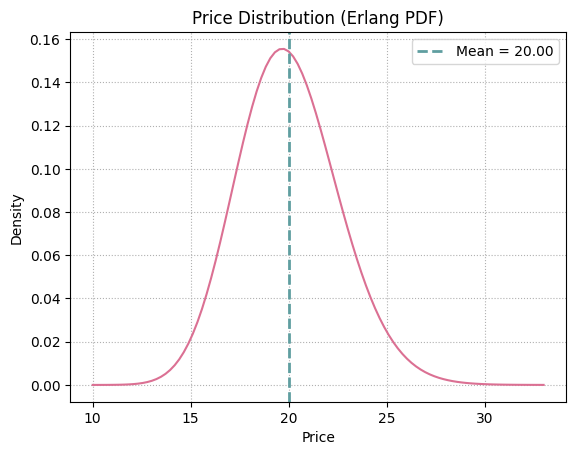

In [4]:
x = np.linspace(S[0], S[1], 100)
y = [pdf(lambda_, k, xi) for xi in x]
mean = k / lambda_

plt.plot(x, y, color = 'palevioletred')
plt.axvline(mean, color = 'cadetblue', linestyle = '--', linewidth = 2, label = f'Mean = {mean:.2f}')
plt.title('Price Distribution (Erlang PDF)')
plt.xlabel('Price')
plt.ylabel('Density')
plt.grid(True, linestyle = ':')
plt.legend()
plt.show()

## Expected revenue

In [5]:
def pi_lb(S):
    return np.clip(0.5 - 0.08 * (S - S0), 0, 0.5)

def pi_ls(S):
    return np.clip(0.5 - 0.08 * (S0 - S), 0, 0.5)

spread_range = np.linspace(0, 10, 100)
spread_range1 = (1 - pi_i) * spread_range
spread_range2 = (1 - pi_i) * spread_range * (pi_lb(S0 + spread_range) + pi_ls(S0 - spread_range))

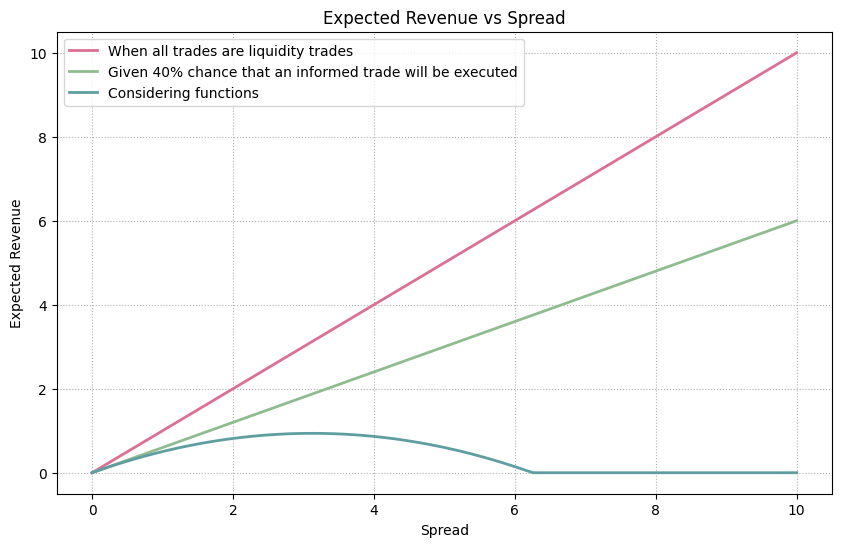

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(spread_range, spread_range, color = 'palevioletred', label = 'When all trades are liquidity trades', linewidth = 2)
plt.plot(spread_range, spread_range1, color = 'darkseagreen', label = 'Given 40% chance that an informed trade will be executed', linewidth = 2)
plt.plot(spread_range, spread_range2, color = 'cadetblue', label = 'Considering functions', linewidth = 2)
plt.title('Expected Revenue vs Spread')
plt.xlabel('Spread')
plt.ylabel('Expected Revenue')
plt.legend()
plt.grid(True, linestyle=':')

## Optimization

In [7]:
def int1(KA):
    return quad(lambda S: (S - KA) * pdf(lambda_, k, S), KA, np.inf)[0]

def int2(KB):
    return quad(lambda S: (KB - S) * pdf(lambda_, k, S), 0, KB)[0]

def fun_obj(x):
    KA, KB = x
    term1 = (1 - pi_i) * (pi_lb(KA) * (KA - S0) + pi_ls(KB) * (S0 - KB))
    term2 = pi_i * (int1(KA) + int2(KB))
    return -(term1 - term2)

res = minimize(fun_obj, x0 = [S0 + 1, S0 - 1], bounds=[(S0, 33), (10, S0)])
KA_opt, KB_opt = res.x

sp = KA_opt - KB_opt

pd.DataFrame({
    "Optimal Ask (KA)": [KA_opt],
    "Optimal Bid (KB)": [KB_opt],
    "Optimal Spread (KA - KB)": [sp]})


,Optimal Ask (KA),Optimal Bid (KB),Optimal Spread (KA - KB)
0,23.427665,16.451678,6.975987


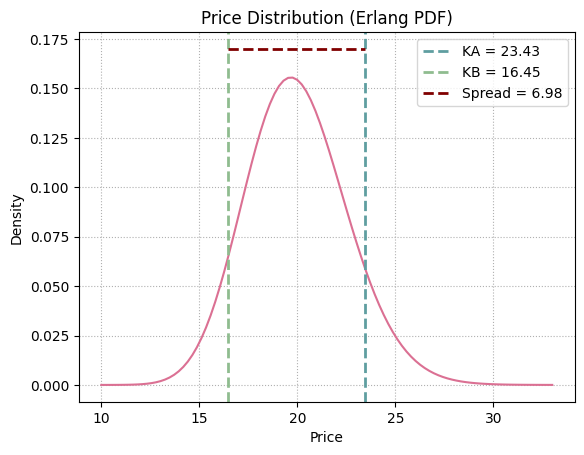

In [8]:
plt.plot(x, y, color = 'palevioletred')
plt.axvline(KA_opt, color = 'cadetblue', linestyle = '--', linewidth = 2, label = f'KA = {KA_opt:.2f}')
plt.axvline(KB_opt, color = 'darkseagreen', linestyle = '--', linewidth = 2, label = f'KB = {KB_opt:.2f}')
plt.hlines(y = 0.17, xmin = KB_opt, xmax = KA_opt, color = 'maroon', linestyles = '--', linewidth = 2, label = f'Spread = {sp:.2f}')
plt.title('Price Distribution (Erlang PDF)')
plt.xlabel('Price')
plt.ylabel('Density')
plt.grid(True, linestyle = ':')
plt.legend()
plt.show()